In [2]:
%reset -f

In [3]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import SubplotSpec

# Pour l'ACP:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# **Boîte à outils**

In [ ]:
def build_autoencoder(input_dim:int,
                      encoder_struct:list,
                      decoder_struct:list,
                      reduced_dim:int,
                      **kwargs):
    
    initializer = kwargs.get('initializer', tfk.initializers.Orthogonal())
    activation = kwargs.get('activation', 'relu')

    #- Encoder

    encoder_input = tfkl.Input(input_dim)
    current = encoder_input

    for units in encoder_struct:
        current = tfkl.Dense(units,
                             activation=activation,
                             kernel_initializer=initializer)(current)
    encoder_output = tfkl.Dense(reduced_dim,
                                activation=activation,
                                kernel_initializer=initializer)(current)

    encoder = tfk.Model(inputs=encoder_input,
                        outputs=encoder_output,
                        name='encoder')
    encoder.compile()

    #- Decoder

    decoder_input = tfkl.Input(reduced_dim)
    current = decoder_input

    for units in decoder_struct:
        current = tfkl.Dense(units,
                             activation=activation,
                             kernel_initializer=initializer)(current)
    decoder_output = tfkl.Dense(input_dim,
                                activation='sigmoid',
                                kernel_initializer=initializer)(current)

    decoder = tfk.Model(inputs=decoder_input, 
                        outputs=decoder_output, 
                        name='decoder')
    decoder.compile()

    #- Composition

    compo_input = tfkl.Input(input_dim)
    compo = tfk.Model(inputs=compo_input,
                      outputs=decoder(encoder(compo_input)),
                      name='composition')
    compo.compile()

    return encoder, decoder, compo

In [ ]:
def plot_some_imgs(imgs, imgs_labels):
    ids = np.random.randint(0, len(imgs), size=(2,10))
    fig, axs = plt.subplots(2,10, figsize=(2*10,2*2), sharex=True, sharey=True, tight_layout=True)
    for i in range(2):
        for j in range(10):
            axs[i,j].imshow(imgs[ids[i,j]], cmap='gray')
            axs[i,j].set_title(str(imgs_labels[ids[i,j]]), fontsize='14')

In [ ]:
def preprocess(imgs):
    return tf.cast(tf.reshape(imgs, (-1, flatten_img_size)), tf.float32) / 255.

In [ ]:
def deprocess(processed_imgs):
    return tf.cast(tf.reshape(processed_imgs, (-1, img_size, img_size)) * 255, tf.int32)

In [ ]:
def plot_training(history):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title('entraînement du modèle', fontsize=16)
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_ylabel('loss', fontsize=14)
    ax.set_xlabel('époque', fontsize=14)
    ax.legend(['train', 'val'], loc='upper right', fontsize=14);

In [ ]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    """
    Sign sets of subplots with title
    from : https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot
    """
    row = fig.add_subplot(grid)
    row.set_title(f'{title}\n', fontsize=16)
    row.set_frame_on(False)
    row.axis('off')

In [ ]:
def plot_some_imgs_and_decoced_imgs(imgs, decoded_imgs):
    ids = np.random.randint(0, len(imgs), size=(10,))

    fig, axs = plt.subplots(2,10, figsize=(2*10,2*2), sharex=True, sharey=True)
    grid = plt.GridSpec(2, 10)
    create_subtitle(fig, grid[0, ::], 'Images originales')
    create_subtitle(fig, grid[1, ::], 'Images reconstruites')
    for j in range(10):
        axs[0,j].imshow(imgs[ids[j]], cmap='gray')
        axs[1,j].imshow(decoded_imgs[ids[j]], cmap='gray')

    fig.tight_layout();

In [ ]:
def plot_some_imgs_and_code(imgs, imgs_labels, coded_imgs):
    position_by_label = {}
    for i in range(10):
        position_by_label[i] = np.where(imgs_labels == i)[0]

    plot_by_label = 4
    label_nb = 10

    fig, axs = plt.subplots(label_nb, 2 * plot_by_label, figsize=(2 * 2 * plot_by_label, 2 * label_nb))

    for nb in range(label_nb):
        for i in range(plot_by_label):
            id = position_by_label[nb][i]
            axs[nb, 2 * i].imshow(imgs[id], cmap='gray')
            axs[nb, 2 * i + 1].imshow(coded_imgs[id].reshape(5,2), cmap='gray')

    plt.suptitle('Images originales et leurs codes respectifs');

In [ ]:
# row = 5
# col = 10
# imgs = np.concatenate(tf.split(np.concatenate([img_train[i] for i in range(row*col)],axis=1), row, axis=1), axis=0)
# fig, ax = plt.subplots(figsize=(10,5))
# ax.imshow(imgs, cmap='gray_r')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# plt.xticks([],[])
# plt.yticks([],[]);

# **Récupération des données**

MNIST est un grand jeu de données de chiffres écrits à la main et de leurs valeurs numériques (que l'auto-encodeur n'utilisera pas).

In [ ]:
(img_train, label_train), (img_val, label_val) = tfk.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Regardons quelques exemples:

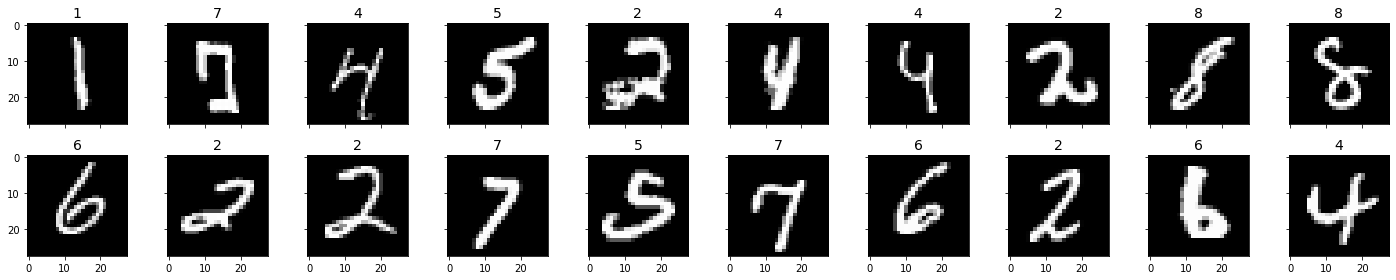

In [ ]:
plot_some_imgs(img_train, label_train)

In [ ]:
print(img_train[0,10:25,10:25])
print('shape d\'une image : ', img_train[0].shape)
print('valeur minimale : ', np.amin(img_train[0]))
print('valeur maximale : ', np.amax(img_train[0]))

[[  1 154 253  90   0   0   0   0   0   0   0   0   0   0   0]
 [  0 139 253 190   2   0   0   0   0   0   0   0   0   0   0]
 [  0  11 190 253  70   0   0   0   0   0   0   0   0   0   0]
 [  0   0  35 241 225 160 108   1   0   0   0   0   0   0   0]
 [  0   0   0  81 240 253 253 119  25   0   0   0   0   0   0]
 [  0   0   0   0  45 186 253 253 150  27   0   0   0   0   0]
 [  0   0   0   0   0  16  93 252 253 187   0   0   0   0   0]
 [  0   0   0   0   0   0   0 249 253 249  64   0   0   0   0]
 [  0   0   0   0  46 130 183 253 253 207   2   0   0   0   0]
 [  0   0  39 148 229 253 253 253 250 182   0   0   0   0   0]
 [ 24 114 221 253 253 253 253 201  78   0   0   0   0   0   0]
 [213 253 253 253 253 198  81   2   0   0   0   0   0   0   0]
 [253 253 253 195  80   9   0   0   0   0   0   0   0   0   0]
 [253 244 133  11   0   0   0   0   0   0   0   0   0   0   0]
 [132  16   0   0   0   0   0   0   0   0   0   0   0   0   0]]
shape d'une image :  (28, 28)
valeur minimale :  0
val

Sauvegardons quelques valeurs intéressantes:

In [ ]:
img_size = img_train.shape[1]
flatten_img_size = img_size * img_size

# **L'auto-encodeur**

## **Préparation des données**

Il faut adapter les données à notre auto-encodeur composé de couches denses:
* il ne travaille que sur la dernière dimension: il faut aplatir les images: on passe d'une entrée de forme (None,28,28) à (None,784),
* une valeur est un entier correspond à l'intensité d'un pixel de 0 à 255: il faut ramener cette valeur sur [0,1].

In [ ]:
flatten_img_train = preprocess(img_train)
flatten_img_val = preprocess(img_val)

In [ ]:
print('shape d\'une image : ', flatten_img_train[0].shape)
print('valeur minimale : ', np.amin(flatten_img_train[0]))
print('valeur maximale : ', np.amax(flatten_img_train[0]))

shape d'une image :  (784,)
valeur minimale :  0.0
valeur maximale :  1.0


## **Construction du modèle:**

On cherche à compresser chaque image de dimension 784 en un code de dimension 10 ! Ici, on construit le décodeur comme une symétrie de l'encodeur.

In [ ]:
input_dim = flatten_img_size
encoder_struct = [512,128]
decoder_struct = encoder_struct[::-1]
reduced_dim = 10 

encoder, decoder, compo = build_autoencoder(input_dim,
                                            encoder_struct,
                                            decoder_struct,
                                            reduced_dim)

In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_12 (Dense)            (None, 512)               401920    
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dense_14 (Dense)            (None, 10)                1290      
                                                                 
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


## **Entraînement**

In [ ]:
compo.compile(loss='mean_squared_error', optimizer = tfk.optimizers.Adam())

In [ ]:
history = compo.fit(flatten_img_train, flatten_img_train, batch_size=64, epochs=15, verbose=1, validation_data=(flatten_img_val, flatten_img_val))

Epoch 1/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0370 - val_loss: 0.0227
Epoch 2/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0210 - val_loss: 0.0191
Epoch 3/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0186 - val_loss: 0.0176
Epoch 4/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0172 - val_loss: 0.0165
Epoch 5/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0164 - val_loss: 0.0159
Epoch 6/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0157 - val_loss: 0.0155
Epoch 7/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 8/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 9/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0145 - val_loss: 0.0146
Epoch 10/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0142 - val_loss: 0.0145

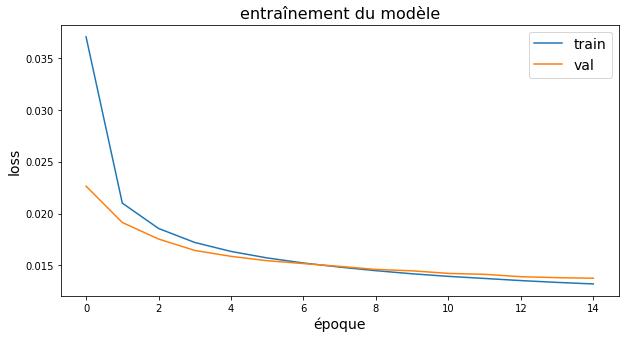

In [ ]:
plot_training(history)

Le modèle est maintenant entraîné, on a peut-être une légère trace de sur-apprentissage.

## **Test**

Peut-on récupérer des images correctes issues de compression ? On compare des images à leurs équivalents compressés puis décompressés.

In [ ]:
coded_flatten_img_val = encoder.predict(flatten_img_val)
decoded_flatten_img_val = decoder.predict(coded_flatten_img_val)
decoded_img_val = deprocess(decoded_flatten_img_val)

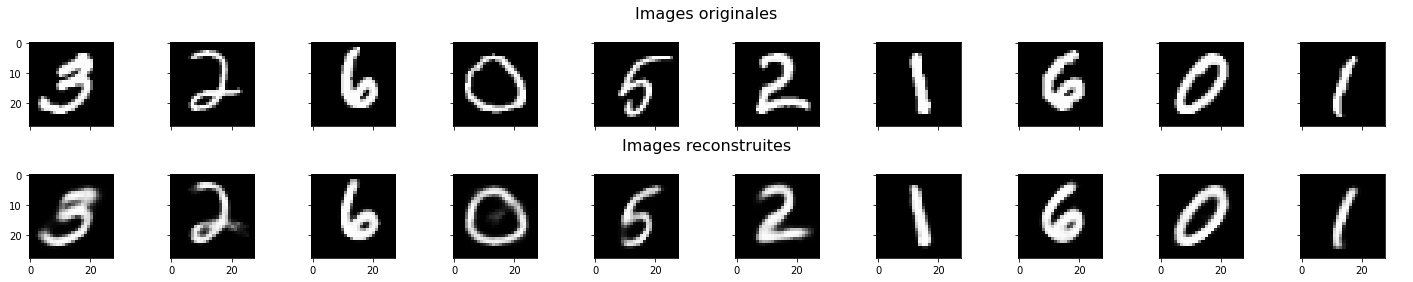

In [ ]:
plot_some_imgs_and_decoced_imgs(img_val, decoded_img_val)

Ce modèle est correct. 

A quoi ressemble le code d'une image donnée ?

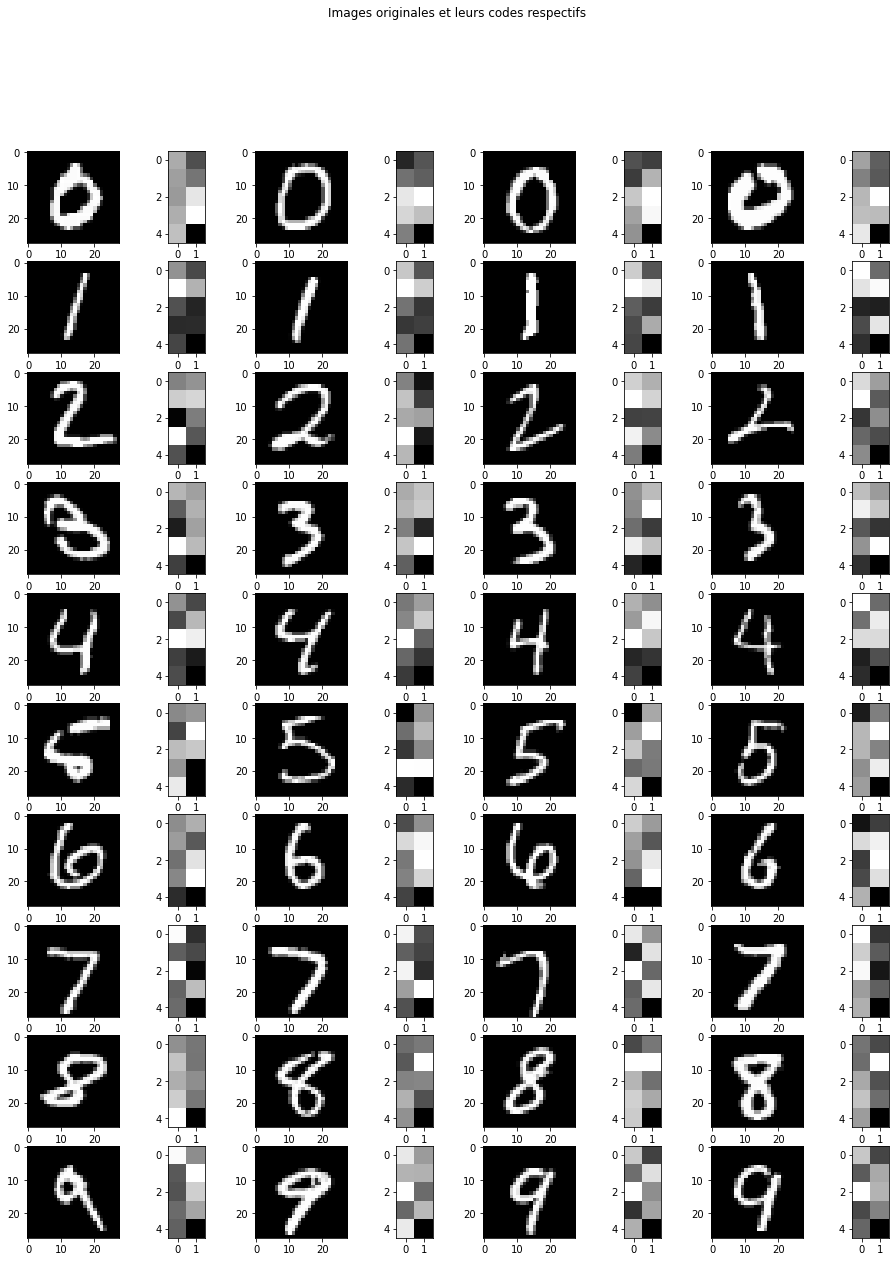

In [ ]:
plot_some_imgs_and_code(img_val, label_val, coded_flatten_img_val)

# **Quid de l'ACP?**

## **ACP**

Pour l'ACP, il faut centrer-réduire les exemples.

In [ ]:
scaler = StandardScaler()
flatten_train_img = scaler.fit_transform(np.reshape(img_train, newshape=(-1, flatten_img_size))) 
flatten_test_img = scaler.transform(np.reshape(img_val, newshape=(-1, flatten_img_size)))

On peut maintenant appliquer l'ACP, on garde 10 comme dimension réduite, pour comparer à l'auto-encodeur. Codons nos images.

In [ ]:
pca = PCA(n_components=10)
coded_flatten_train_img = pca.fit_transform(flatten_train_img)
coded_flatten_test_img = pca.transform(flatten_test_img)

Enfin, on reconstruit les images à partir de leurs codes.

In [ ]:
decoded_train_img = np.reshape(scaler.inverse_transform(pca.inverse_transform(coded_flatten_train_img)), newshape=(-1, img_size, img_size))
decoded_test_img = np.reshape(scaler.inverse_transform(pca.inverse_transform(coded_flatten_test_img)), newshape=(-1, img_size, img_size))

## **Test**

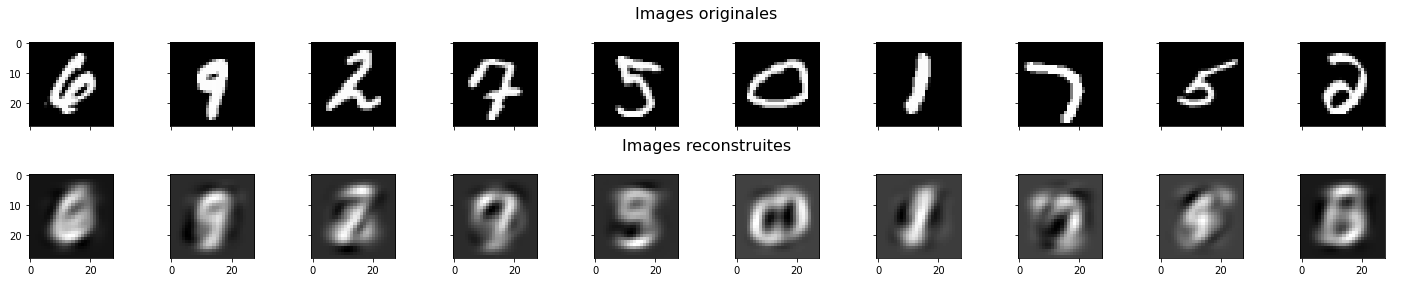

In [ ]:
plot_some_imgs_and_decoced_imgs(img_val, decoded_test_img)

Ce n'est pas bon ; regardons la portion de variance expliquée:

In [ ]:
print(f'pourcentage de variance expliquée : {sum(pca.explained_variance_ratio_) * 100} %')

pourcentage de variance expliquée : 27.670637166108214 %


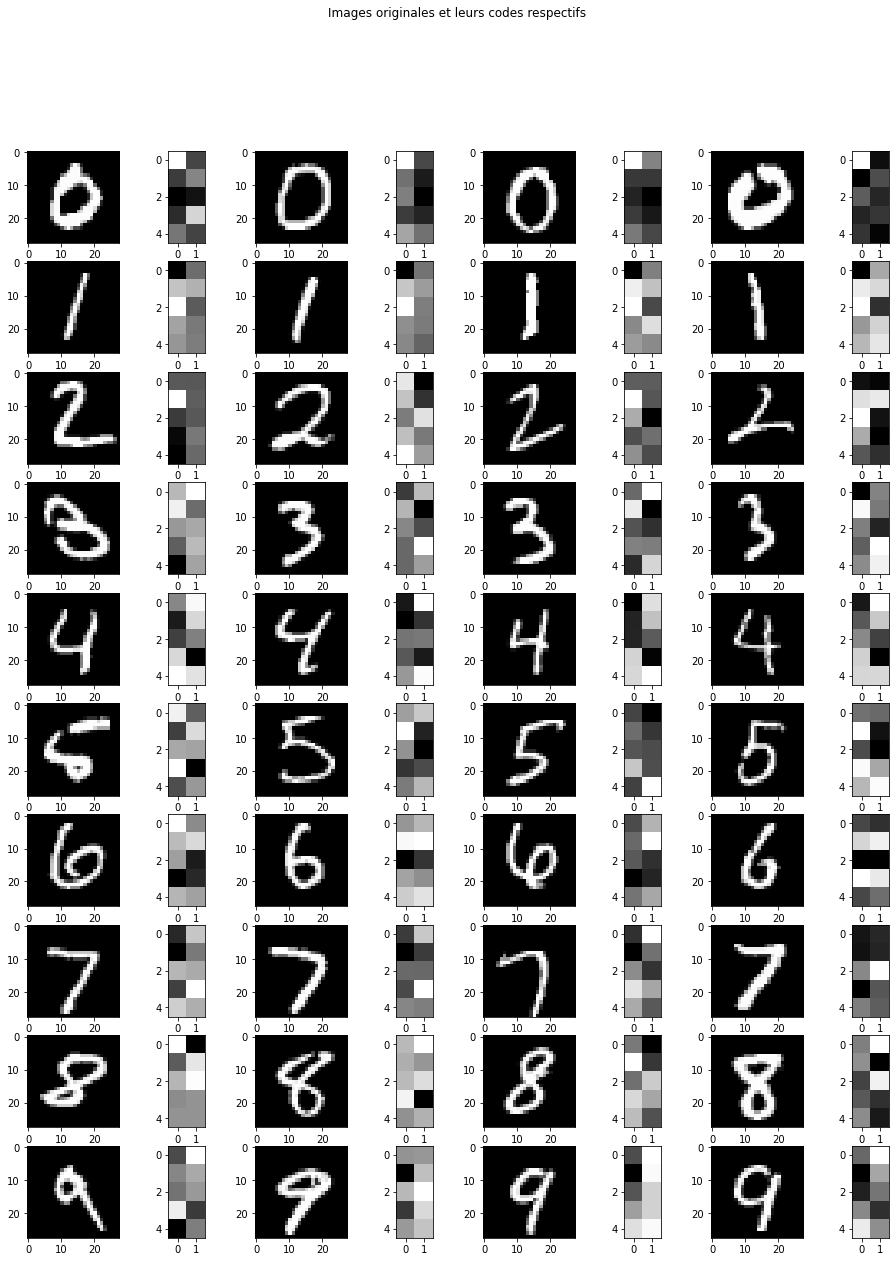

In [ ]:
plot_some_imgs_and_code(img_val, label_val, coded_flatten_test_img)

Combien aurait-il fallu de composantes pour expliquer 90% de la variance ?

In [ ]:
pca = PCA(n_components=0.9)

In [ ]:
print(len(pca.components_))

236


Il en aurait fallu 236 (pour une donnée en dimension 784)!

In [ ]:
coded_flatten_train_img = pca.fit_transform(flatten_train_img)
coded_flatten_test_img = pca.transform(flatten_test_img)
decoded_train_img = np.reshape(scaler.inverse_transform(pca.inverse_transform(coded_flatten_train_img)), newshape=(-1, img_size, img_size))
decoded_test_img = np.reshape(scaler.inverse_transform(pca.inverse_transform(coded_flatten_test_img)), newshape=(-1, img_size, img_size))

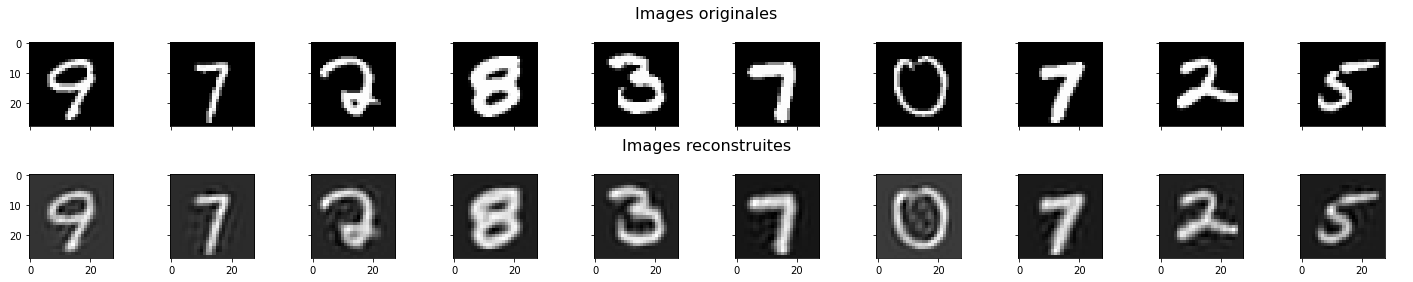

In [ ]:
plot_some_imgs_and_decoced_imgs(img_val, decoded_test_img)